<a href="https://colab.research.google.com/github/souldrive7/ECP/blob/main/modeling_kadai_goto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# モデリング基礎実践論 課題（土田先生）



提出日：2025/5/11

学籍番号：6025131

氏名：後藤 晃郁

# 課題

---



次の中から少なくとも 1つ を選んで、提出すること。

1.内点法について説明せよ。具体的な例について計算機による実装を行い、シンプレックス法との計算量・計算時間を比較せよ。

2.整数計画問題について説明せよ。近似解法についても説明を与え、具体的な例に対して計算機による実装を行え。

3.ネットワーク計画問題について説明せよ。具体例を挙げ、計算機による実装を行え。

---

# 1.内点法について説明せよ。具体的な例について計算機による実装を行い、シンプレックス法との計算量・計算時間を比較せよ。

# 2.整数計画問題について説明せよ。近似解法についても説明を与え、具体的な例に対して計算機による実装を行え。


# 3.ネットワーク計画問題について説明せよ。具体例を挙げ、計算機による実装を行え。

---
■問題の定義と目的■

**ネットワーク計画問題とは**:

プロジェクトを構成する複数の作業を、順序関係と所要時間を持つネットワーク（有向非巡回グラフ）として表現し、プロジェクトの最短完了時間や、全体の進行に影響するクリティカルパスを特定する問題のことをいう。

**目的**:

- プロジェクトの所要時間の把握

- 遅延リスクのある作業（クリティカルパス）の特定

- 余裕時間（フロート）を活かした進行・資源計画

- 不確実性がある場合は遅延の確率的評価
---

■手法（CPM法とPERT法）■

**CPM法（Critical Path Method）**:決定論的アプローチ

- 作業時間が確定している前提で進行

- 最早開始/終了時刻（ES/EF）と最遅開始/終了時刻（LS/LF）を算出

- フロートを計算し、フロートが0の作業列をクリティカルパスと判断

**PERT法（Program Evaluation and Review Technique）**:確率論的アプローチ

- 作業時間を確率変数として扱う

- プロジェクト完了時間の期待値と標準偏差を求め、確率的に遅延リスクを評価

- 各作業に対して以下の3点見積もりを用いる：

  楽観値（$a$）, 最可能値（$m$）, 悲観値（$b$）

  期待時間 $E = \frac{a + 4m + b}{6}$

  分散 $Var = \left(\frac{b - a}{6}\right)^2$

---

■具体例・モデル化■

以下の作業リストを対象として、CPM・PERT両方を適用した。



In [ ]:
import pandas as pd
from IPython.display import display

# CPM・PERT対象作業リスト（データ＋表示）
print("\n以下の作業リストを対象として、CPM・PERT両方を適用した。")

data = [
    ['A', '-',      4, 3, 4, 5],
    ['B', 'A',      3, 2, 3, 5],
    ['C', 'A',      5, 4, 5, 6],
    ['D', 'B',      6, 5, 6, 8],
    ['E', 'B',      4, 3, 4, 6],
    ['F', 'C',      3, 2, 3, 4],
    ['G', 'D, E',   5, 4, 5, 7],
    ['H', 'F',      2, 1, 2, 3],
    ['I', 'G',      3, 2, 3, 4],
    ['J', 'H, I',   2, 1, 2, 3]
]

columns = ['作業', '先行作業', '所要時間（CPM）', '楽観値 (a)', '最可能値 (m)', '悲観値 (b)']
df = pd.DataFrame(data, columns=columns)

styled_df = df.style.set_properties(**{'text-align': 'center'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
)
display(styled_df)

print("\nこの構成により、複雑な依存関係を持つプロジェクト全体が有向非巡回グラフ（DAG）として表現される。")


以下の作業リストを対象として、CPM・PERT両方を適用した。


,作業,先行作業,所要時間（CPM）,楽観値 (a),最可能値 (m),悲観値 (b)
0,A,-,4,3,4,5
1,B,A,3,2,3,5
2,C,A,5,4,5,6
3,D,B,6,5,6,8
4,E,B,4,3,4,6
5,F,C,3,2,3,4
6,G,"D, E",5,4,5,7
7,H,F,2,1,2,3
8,I,G,3,2,3,4
9,J,"H, I",2,1,2,3



この構成により、複雑な依存関係を持つプロジェクト全体が有向非巡回グラフ（DAG）として表現される。


■実装■

Python（NetworkX）を用いて、トポロジカル順に CPM の ES, EF, LS, LF を計算し、さらに各作業の期待時間と分散（PERT）も算出した。

In [ ]:
import networkx as nx
import math

# 必要な事前データ（例）
G = nx.DiGraph()
tasks = {
    'A': ([], 4, 3, 4, 5),
    'B': (['A'], 3, 2, 3, 5),
    'C': (['A'], 5, 4, 5, 6),
    'D': (['B'], 6, 5, 6, 8),
    'E': (['B'], 4, 3, 4, 6),
    'F': (['C'], 3, 2, 3, 4),
    'G': (['D', 'E'], 5, 4, 5, 7),
    'H': (['F'], 2, 1, 2, 3),
    'I': (['G'], 3, 2, 3, 4),
    'J': (['H', 'I'], 2, 1, 2, 3)
}
for task, (preds, duration, a, m, b) in tasks.items():
    G.add_node(task,
               duration=duration,
               pert_expect=(a + 4 * m + b) / 6,
               pert_var=((b - a) / 6) ** 2)
    for pred in preds:
        G.add_edge(pred, task)

# CPM計算（ES, EF, LS, LF）
ES, EF = {}, {}
for node in nx.topological_sort(G):
    es = max([EF[p] for p in G.predecessors(node)], default=0)
    ef = es + G.nodes[node]['duration']
    ES[node], EF[node] = es, ef
project_duration = max(EF.values())

LF, LS = {}, {}
for node in reversed(list(nx.topological_sort(G))):
    lf = min([LS[s] for s in G.successors(node)], default=project_duration)
    ls = lf - G.nodes[node]['duration']
    LF[node], LS[node] = lf, ls

# 表形式出力
header = f"{'作業':<2} | {'ES':>1} | {'EF':>1} | {'LS':>1} | {'LF':>1} | {'フロート':>3} | {'クリティカルパス':^4} | {'PERT期待':>8} | {'分散':^4}"
print(header)
print("--" * len(header))

total_pert_var = 0
for node in nx.topological_sort(G):
    es, ef = ES[node], EF[node]
    ls, lf = LS[node], LF[node]
    float_time = ls - es
    is_critical = float_time == 0
    crit_mark = "〇" if is_critical else "　"
    pert_e = G.nodes[node]['pert_expect']
    pert_v = G.nodes[node]['pert_var']
    if is_critical:
        total_pert_var += pert_v
    print(f"{node:<4} | {es:>2} | {ef:>2} | {ls:>2} | {lf:>2} | {float_time:>8} | {crit_mark:^15} | {pert_e:>10.2f} | {pert_v:>6.3f}")

# PERT結果
pert_std = math.sqrt(total_pert_var)
print(f"\n■CPM：プロジェクト完了の最短所要時間 ≈ {project_duration}日")
print(f"■PERT期待完了時間 ≈ {EF['J']}日，標準偏差 ≈ {pert_std:.2f}日")


作業 | ES | EF | LS | LF | フロート | クリティカルパス |   PERT期待 |  分散 
--------------------------------------------------------------------------------------------------------------------
A    |  0 |  4 |  0 |  4 |        0 |        〇        |       4.00 |  0.111
B    |  4 |  7 |  4 |  7 |        0 |        〇        |       3.17 |  0.250
C    |  4 |  9 | 11 | 16 |        7 |        　        |       5.00 |  0.111
D    |  7 | 13 |  7 | 13 |        0 |        〇        |       6.17 |  0.250
E    |  7 | 11 |  9 | 13 |        2 |        　        |       4.17 |  0.250
F    |  9 | 12 | 16 | 19 |        7 |        　        |       3.00 |  0.111
G    | 13 | 18 | 13 | 18 |        0 |        〇        |       5.17 |  0.250
H    | 12 | 14 | 19 | 21 |        7 |        　        |       2.00 |  0.111
I    | 18 | 21 | 18 | 21 |        0 |        〇        |       3.00 |  0.111
J    | 21 | 23 | 21 | 23 |        0 |        〇        |       2.00 |  0.111

■CPM：プロジェクト完了の最短所要時間 ≈ 23日
■PERT期待完了時間 ≈ 23日，標準偏差 ≈ 1.04日


結果：

CPMによる最短完了時間：23日

PERTによる期待完了時間：23日（※一致を確認）

クリティカルパス：A → B → D → G → I → J

クリティカルパス上の標準偏差（遅延リスク指標）：約 1.04日

→ 正規分布近似による、95%信頼区間 ≈ 23 ± 1.96×1.04 ≈ [20.96日, 25.04日]

---
■可視化■

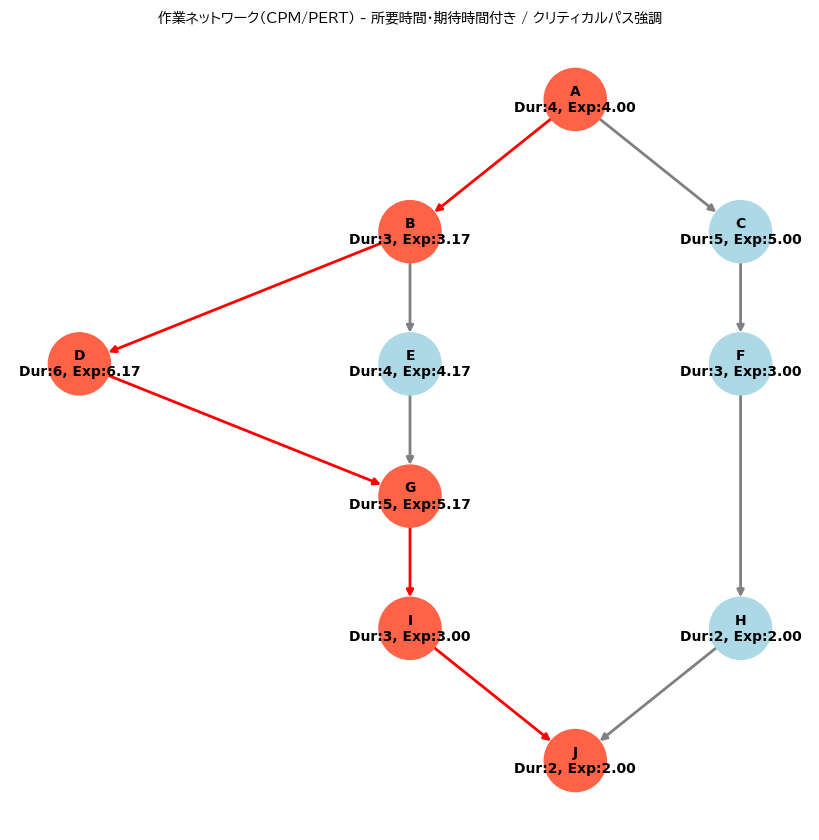

In [15]:
import os
import urllib.request
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ▼ フォント準備（ダウンロード済ならスキップ）
font_path = "BIZUDPGothic-Regular.ttf"
if not os.path.exists(font_path):
    font_url = "https://github.com/googlefonts/morisawa-biz-ud-gothic/raw/main/fonts/ttf/BIZUDPGothic-Regular.ttf"
    urllib.request.urlretrieve(font_url, font_path)

font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# ▼ 作業データ
task_info = {
    'A': {'pred': [],       'duration': 4, 'expect': 4.0,  'critical': True},
    'B': {'pred': ['A'],    'duration': 3, 'expect': 3.17, 'critical': True},
    'C': {'pred': ['A'],    'duration': 5, 'expect': 5.0,  'critical': False},
    'D': {'pred': ['B'],    'duration': 6, 'expect': 6.17, 'critical': True},
    'E': {'pred': ['B'],    'duration': 4, 'expect': 4.17, 'critical': False},
    'F': {'pred': ['C'],    'duration': 3, 'expect': 3.0,  'critical': False},
    'G': {'pred': ['D', 'E'],'duration': 5, 'expect': 5.17, 'critical': True},
    'H': {'pred': ['F'],    'duration': 2, 'expect': 2.0,  'critical': False},
    'I': {'pred': ['G'],    'duration': 3, 'expect': 3.0,  'critical': True},
    'J': {'pred': ['H', 'I'],'duration': 2, 'expect': 2.0,  'critical': True}
}

# ▼ DAG構築
G = nx.DiGraph()
for task, info in task_info.items():
    G.add_node(task, duration=info['duration'], expect=info['expect'], critical=info['critical'])
    for pred in info['pred']:
        G.add_edge(pred, task)


# ▼ ラベル・色設定
labels = {
    node: f"{node}\nDur:{G.nodes[node]['duration']}, Exp:{G.nodes[node]['expect']:.2f}"
    for node in G.nodes
}
node_colors = ['tomato' if G.nodes[node]['critical'] else 'lightblue' for node in G.nodes]
edge_colors = ['red' if G.nodes[u]['critical'] and G.nodes[v]['critical'] else 'gray' for u, v in G.edges]
pos = nx.nx_pydot.graphviz_layout(G, prog='dot')

# ▼ 描画
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=False, arrows=True, node_size=2000,
        node_color=node_colors, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_weight='bold')

plt.title("作業ネットワーク（CPM/PERT） - 所要時間・期待時間付き / クリティカルパス強調", fontproperties=font_prop)
plt.axis('off')
plt.tight_layout()
plt.show()
